# Load Imports

In [1]:
import os
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import random
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
# Define the directories for the dataset
train_dir = "C:/Users/bened/Documents/Alyster Coding/PROJECTS/CV/dataset/car/train" # images, labels (bounding boxes)

# Preprocessing (Images and Annoations)

In [3]:
# Function to load and normalize images and bounding boxes
def load_images_and_bboxes(img_dir, label_dir, img_size=(224, 224)):
    images = []
    bboxes = []

    for filename in os.listdir(img_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Load image
            img_path = os.path.join(img_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)  # Resize to uniform size
            img = img.astype('float32') / 255.0  # Normalize image to [0, 1]
            images.append(img)

            # Load label (bounding box) if present
            label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = f.read().strip().split()  # Assuming [class, x_min, y_min, x_max, y_max]
                    if len(label) >= 5:
                        # Extract bounding box: [x_min, y_min, x_max, y_max]
                        bbox = [float(val) for val in label[1:5]]  # Skip the class value
                        bboxes.append(bbox)
                    else:
                        bboxes.append([0, 0, 0, 0])  # Default placeholder if label is malformed
            else:
                bboxes.append([0, 0, 0, 0])  # Placeholder for non-annotated images

    return np.array(images), np.array(bboxes)


# Load the data
X, y = load_images_and_bboxes(os.path.join(train_dir, 'images'), os.path.join(train_dir, 'labels'))

In [4]:
X[0]

array([[[0.60784316, 0.37254903, 0.2627451 ],
        [0.6039216 , 0.36862746, 0.25490198],
        [0.6       , 0.3647059 , 0.2509804 ],
        ...,
        [0.28627452, 0.2901961 , 0.30980393],
        [0.32156864, 0.39607844, 0.43529412],
        [0.2627451 , 0.38039216, 0.42745098]],

       [[0.6117647 , 0.3764706 , 0.2627451 ],
        [0.60784316, 0.37254903, 0.25882354],
        [0.6       , 0.3647059 , 0.2509804 ],
        ...,
        [0.21960784, 0.22745098, 0.23921569],
        [0.23137255, 0.29411766, 0.31764707],
        [0.23921569, 0.34509805, 0.3764706 ]],

       [[0.6117647 , 0.38039216, 0.2627451 ],
        [0.60784316, 0.37254903, 0.25882354],
        [0.6039216 , 0.36862746, 0.25490198],
        ...,
        [0.25882354, 0.2627451 , 0.2627451 ],
        [0.3647059 , 0.40784314, 0.4117647 ],
        [0.27058825, 0.34117648, 0.34901962]],

       ...,

       [[0.14901961, 0.23921569, 0.29803923],
        [0.15294118, 0.24313726, 0.3019608 ],
        [0.15686275, 0

In [5]:
y

array([[0.53365385, 0.31730769, 0.16947115, 0.31730769],
       [0.57692308, 0.36057692, 0.41586538, 0.27524038],
       [0.51802885, 0.48557692, 0.62259615, 0.45072115],
       ...,
       [0.66947115, 0.43629808, 0.27283654, 0.43870192],
       [0.64302885, 0.48677885, 0.58413462, 0.85336538],
       [0.50120192, 0.30649038, 0.65024038, 0.44591346]])

# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


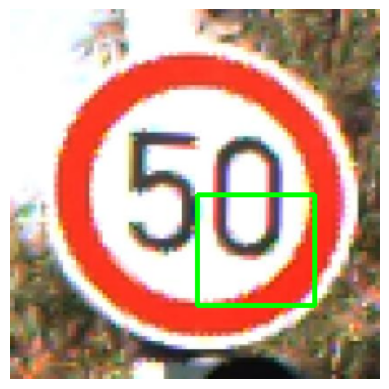

In [6]:
# Function to display a random image with its corresponding bounding box
def display_random_image_with_bbox(images, bboxes):
    # Choose a random index
    random_index = random.randint(0, len(images) - 1)
    
    # Get image and corresponding bounding box
    img = images[random_index]
    bbox = bboxes[random_index]

    # Convert from BGR to RGB for plotting
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert bbox coordinates back to pixel values (relative to image size)
    img_height, img_width = img.shape[:2]
    x_min, y_min, x_max, y_max = bbox
    x_min = int(x_min * img_width)
    y_min = int(y_min * img_height)
    x_max = int(x_max * img_width)
    y_max = int(y_max * img_height)

    # Draw the bounding box
    image_with_bbox = cv2.rectangle(image_rgb, 
                                    (x_min, y_min), 
                                    (x_max, y_max), 
                                    (0, 255, 0), 2)  # Green bounding box

    # Display the image
    plt.imshow(image_with_bbox)
    plt.axis('off')  # Hide axis
    plt.show()

# Example: Display a random image from training set with bounding box
display_random_image_with_bbox(X, y)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


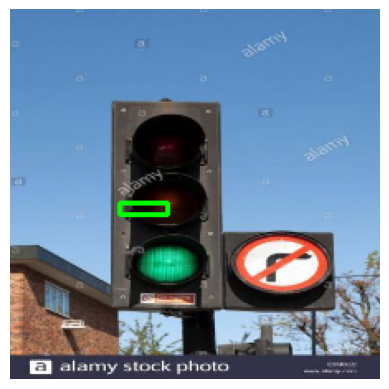

In [7]:
# Example: Display a random image from training set with bounding box
display_random_image_with_bbox(X, y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


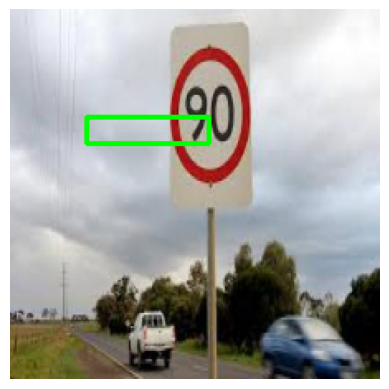

In [8]:
# Example: Display a random image from training set with bounding box
display_random_image_with_bbox(X, y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


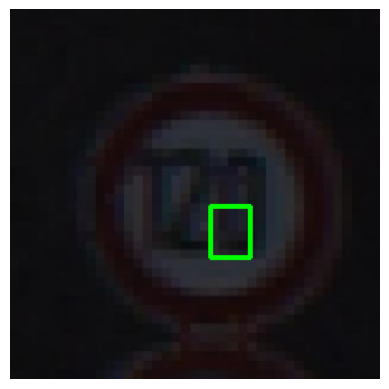

In [9]:
# Example: Display a random image from training set with bounding box
display_random_image_with_bbox(X, y)

# Train Test Split

In [10]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

In [11]:
import pickle
# Build the CNN model using transfer learning (ResNet50 as an example)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Create the custom head for the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(4, activation='sigmoid')  # 4 outputs for bbox coordinates
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['accuracy'])

# Train the model using the training data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# ======== Save the model as .h5 ========
model.save("resnet50_bbox_model.h5")

# ======== Save the model as .pkl ========
model_wrapper = {
    'model': model
}
with open("resnet50_bbox_model.pkl", "wb") as f:
    pickle.dump(model_wrapper, f)

Epoch 1/10
89/89 [==============================] - 76s 834ms/step - loss: 0.0438 - accuracy: 0.3693 - val_loss: 0.0356 - val_accuracy: 0.3796
Epoch 2/10
89/89 [==============================] - 72s 810ms/step - loss: 0.0331 - accuracy: 0.4196 - val_loss: 0.0291 - val_accuracy: 0.4405
Epoch 3/10
89/89 [==============================] - 72s 815ms/step - loss: 0.0277 - accuracy: 0.4554 - val_loss: 0.0254 - val_accuracy: 0.4858
Epoch 4/10
89/89 [==============================] - 71s 799ms/step - loss: 0.0243 - accuracy: 0.4986 - val_loss: 0.0218 - val_accuracy: 0.5836
Epoch 5/10
89/89 [==============================] - 73s 823ms/step - loss: 0.0220 - accuracy: 0.5223 - val_loss: 0.0214 - val_accuracy: 0.4476
Epoch 6/10
89/89 [==============================] - 75s 850ms/step - loss: 0.0202 - accuracy: 0.5577 - val_loss: 0.0186 - val_accuracy: 0.6091
Epoch 7/10
89/89 [==============================] - 76s 855ms/step - loss: 0.0189 - accuracy: 0.5591 - val_loss: 0.0179 - val_accuracy: 0.4844

c:\Users\bened\anaconda3\envs\traffic-detection\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation

In [12]:

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")
print(f"Test loss: {test_loss:.2f}")

23/23 [==============================] - 15s 661ms/step - loss: 0.0154 - accuracy: 0.6133
Test accuracy: 0.61
Test loss: 0.02


# Detection System

(416, 416, 3)
1/1 [==============================] - 1s 529ms/step
Predicted bounding box (normalized): [0.5011271  0.4840216  0.45308307 0.47012383]
Bounding box coordinates on the original image: (208, 201), (188, 195)


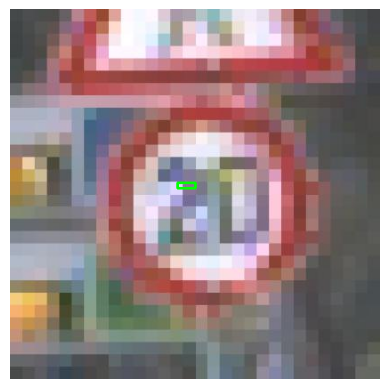

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to predict and visualize bounding box
def predict_and_visualize(model, image_path):
    # Load the original image
    image = cv2.imread(image_path)
    
    # Store the original image shape
    original_height, original_width, _ = image.shape
    print(image.shape)
    # Resize the image to the model input size (224x224)
    image_resized = cv2.resize(image, (224, 224))  # Resize for model input
    image_normalized = image_resized / 255.0  # Normalize the image
    image_expanded = np.expand_dims(image_normalized, axis=0)  # Add batch dimension

    # Make prediction
    predicted_bbox = model.predict(image_expanded)  # Get predicted bounding box
    predicted_bbox = predicted_bbox[0]  # Get the first prediction (batch size = 1)
    
    print(f"Predicted bounding box (normalized): {predicted_bbox}")
    
    # Convert the predicted bounding box from [0,1] range to pixel values
    x_min, y_min, x_max, y_max = predicted_bbox
    
    # Scale the bounding box coordinates to the original image size
    x_min = int(x_min * original_width)
    y_min = int(y_min * original_height)
    x_max = int(x_max * original_width)
    y_max = int(y_max * original_height)
    
    # Ensure bounding box is valid (coordinates within the image dimensions)
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(original_width, x_max)
    y_max = min(original_height, y_max)
    
    print(f"Bounding box coordinates on the original image: ({x_min}, {y_min}), ({x_max}, {y_max})")
    
    # Draw the bounding box on the original image
    image_with_bbox = cv2.rectangle(image.copy(), 
                                    (x_min, y_min), 
                                    (x_max, y_max), 
                                    (0, 255, 0), 2)  # Green bounding box

    # Display the image with the bounding box
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.axis('off')  # Hide axis
    plt.show()

# Example: Test the function on a sample image
image_path = "C:/Users/bened/Documents/Alyster Coding/PROJECTS/CV/dataset/car/train/images/00000_00000_00001_png.rf.8bc8cc5e727cfd7e81b5184a15dd6fc1.jpg"  # Example path
predict_and_visualize(model, image_path)  # Predict and visualize the bounding box


(416, 416, 3)
1/1 [==============================] - 0s 67ms/step
Predicted bounding box (normalized): [0.50473815 0.5238398  0.60080683 0.6220127 ]
Bounding box coordinates on the original image: (209, 217), (249, 258)


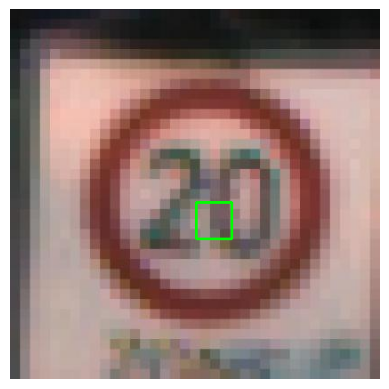

In [17]:
# Example: Test the function on a sample image
image_path = "C:/Users/bened/Documents/Alyster Coding/PROJECTS/CV/dataset/car/test/images/00000_00003_00011_png.rf.7d5f2a85458f70654be03f2a2cd47c06.jpg"   # Path to the sample image
predict_and_visualize(model, image_path)  # Predict and visualize the bounding box

In [1]:
import cv2
print(cv2.__version__)

4.11.0


In [2]:
import sys
print(sys.executable)

c:\Users\bened\anaconda3\envs\traffic-detection\python.exe
